# Test (randUP) and (robUP!) on neural network dynamics (trained on LTI)

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.spatial import ConvexHull
import time

from models.LTI_sim import LTISimulator
from models.feedforward import FeedForward, FeedForwardDynamics

from utils.stats import sample_pts_in_ellipsoid, volume_ellipsoid
from utils.viz import plot_ellipse

In [2]:
simulator = LTISimulator()
x_dim, u_dim = simulator.n_x, simulator.n_u
simulator

## Load model

In [3]:
filename = 'trained_models/feedforward_hid128'
model = FeedForwardDynamics(FeedForward(model_path=filename).float(), 
                            dt=float(simulator.dt))
# print('Lipschitz constant         = ', model.get_upper_bound_lipschitz_constant())
# print('Vec of Lipschitz constants = ', model.get_upper_bound_lipschitz_constants_vec())

loading state dict


### true trajectory 

In [4]:
# Define states/controls (obtained as a solution in dual_ff_linear)
Xtraj = np.load('data/traj_reach/Xtraj.npy').T[:,:4]
Utraj = np.load('data/traj_reach/Utraj.npy').T[:,:2]
T     = Utraj.shape[0]

In [5]:
num_samples = 100
mu_init = Xtraj[0,:]
Q_init  = 1e-3*np.diag(np.array([5,5,1,1]))
Xs_init = sample_pts_in_ellipsoid(mu_init, Q_init, num_samples).T

# True

In [6]:
Xs_true, Us_true, Qs_true = np.zeros((T+1, x_dim)), Utraj.copy(), np.zeros((T+1, x_dim, x_dim))

Xs_true[0,:]   = mu_init.copy()
Qs_true[0,:,:] = Q_init.copy()
for t in range(T):
    Xs_true[t+1,:]   = simulator.f_dt(Xs_true[t,:], Us_true[t,:])
    Qs_true[t+1,:,:] = simulator.A @ Qs_true[t,:,:] @ simulator.A.T

# (randUP)

In [7]:
# sample the models
dyn_fn_randUP = model.get_model(with_grad=True, n_samples=num_samples)
# simulate forward
Xs_randUP        = np.zeros((num_samples,T+1,x_dim))
Xs_randUP_dx     = np.zeros((num_samples,T+1,x_dim,x_dim))
# for i in range(num_samples):
Xs_randUP[:,0,:]      = Xs_init
Xs_randUP_dx[:,0,:,:] = np.zeros((num_samples,x_dim,x_dim))
for t in range(T):
    um            = np.repeat( Us_true[t,:][None,:], num_samples, axis=0 ) 
    x, x_dx, x_du = dyn_fn_randUP(Xs_randUP[:,t,:], um)
    Xs_randUP[:,t+1,:]     = x
    Xs_randUP_dx[:,t,:,:]  = x_dx

# (robUP!)

In [8]:
model.X0s_MC = Xs_init.copy()
model.mu_0   = mu_init.copy()
model.Q_0    = Q_init.copy()

In [9]:
# sample the models
model.X0s_MC = Xs_init.copy()
model.adv_sample_params(Xs_randUP, Xs_randUP_dx)
dyn_fn_robUP = model.get_model(with_grad=False, n_samples=num_samples)
# simulate forward
Xs_robUP = np.zeros((num_samples,T+1,x_dim))

Xs_robUP[:,0,:] = model.X0s_MC
for t in range(T):
    um  = np.repeat( Us_true[t,:][None,:], num_samples, axis=0 ) 
    Xs_robUP[:,t+1,:] = dyn_fn_robUP(Xs_robUP[:,t,:], um)

In [10]:
np.linalg.norm(model.X0s_MC-Xs_init)

0.14090423490418436

# Lipschitz

In [11]:
dyn_fn_lip = model.get_model(n_samples=1)

mus_lip = np.zeros((T+1,x_dim))
Qs_lip  = np.zeros((T+1,x_dim,x_dim))
mus_lip[0,:]  = mu_init
Qs_lip[0,:,:] = Q_init
for t in range(T):
    mus_lip[t+1,:]  = dyn_fn_lip(mus_lip[t,:], Us_true[t,:])
    Qs_lip[t+1,:,:] = model.propagate_ellipsoid_lipschitz(mus_lip[t,:], Us_true[t,:], Qs_lip[t,:,:])

# Plot results

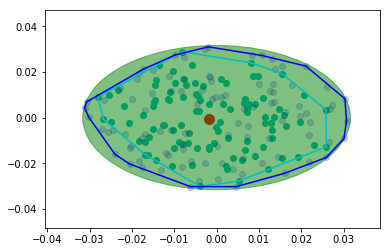

In [12]:
k   = 0
idx = [0,1]
idx = [2,3]

# randUP
plt.scatter(Xs_randUP[:,k,idx[0]],Xs_randUP[:,k,idx[1]],         color='c')
hull = ConvexHull(Xs_randUP[:,k,idx])
for simplex in hull.simplices:
    plt.plot(Xs_randUP[simplex,k,idx[0]], Xs_randUP[simplex,k,idx[1]], 'c-')
    
# robUP!
plt.scatter(Xs_robUP[:,k,idx[0]],Xs_robUP[:,k,idx[1]],             color='b', alpha=0.2)
hull = ConvexHull(Xs_robUP[:,k,idx])
for simplex in hull.simplices:
    plt.plot(Xs_robUP[simplex,k,idx[0]], Xs_robUP[simplex,k,idx[1]], 'b-')

# center
center = np.mean(Xs_randUP,0)[k,idx] # (T+1, x_dim)
plt.scatter(center[0], center[1], color='r', s=100)

# true ellipsoid
ax = plt.gca()
mu_k, Q_k =  Xs_true[k,idx], Qs_true[k,:,:] 
plot_ellipse(ax, mu_k, Q_k[np.ix_(idx,idx)], color='g', alpha=0.5)

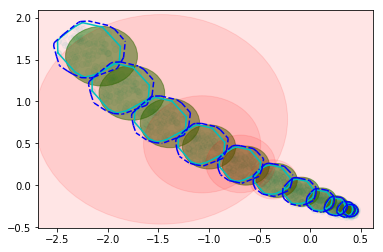

In [13]:
idx = [0,1]

for k in range(1,T):
    plt.scatter(Xs_randUP[:,k,idx[0]],Xs_randUP[:,k,idx[1]], color='c', alpha=0.05)
    hull_randUP = ConvexHull(Xs_randUP[:,k,idx])
    for simplex in hull_randUP.simplices:
        plt.plot(Xs_randUP[simplex,k,idx[0]], Xs_randUP[simplex,k,idx[1]], 'c-')

for k in range(1,T):
    hull = ConvexHull(Xs_robUP[:,k,idx])
    for simplex in hull.simplices:
        plt.plot(Xs_robUP[simplex,k,idx[0]], Xs_robUP[simplex,k,idx[1]], 'b--')

ax = plt.gca()
for k in range(T):
    # True
    mu_k, Q_k =  Xs_true[k,idx], Qs_true[k,:,:] 
    plot_ellipse(ax, mu_k, Q_k[np.ix_(idx,idx)], color='g', alpha=0.5)
    
for k in range(1,T-1):
    # lipschitz
    mu_k, Q_k =  mus_lip[k,idx], Qs_lip[k,:,:] 
    plot_ellipse(ax, mu_k, Q_k[np.ix_(idx,idx)], color='r', alpha=0.1)

In [14]:
k = 4
print('vol_randUP = ', ConvexHull(Xs_randUP[:,k,:]).volume)
print('vol_robUP = ', ConvexHull(Xs_robUP[:,k,:]).volume)
print('vol_lip = ', volume_ellipsoid(Qs_lip[k,:,:]))

vol_randUP =  9.117877638447454e-06
vol_robUP =  1.5762697759515117e-05
vol_lip =  0.00016930682690999405
